In [1]:
import torch
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images
from vggt.utils.pose_enc import pose_encoding_to_extri_intri
from vggt.utils.geometry import unproject_depth_map_to_point_map

import open3d as o3d
import numpy as np
import os
import glob
from matplotlib import pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = torch.bfloat16 if torch.cuda.get_device_capability()[0] >= 8 else torch.float16

In [3]:
model = VGGT()
_URL = "./model.pt"
model.load_state_dict(torch.load(_URL))
model.eval()
model = model.to(device)

/tmp/ipykernel_139539/2406001790.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(_URL))


In [4]:
path = "./test_model/black1_16view"

image_names = sorted(glob.glob(os.path.join(path, "*.png")))
images = load_and_preprocess_images(image_names).to(device)

with torch.no_grad():
    with torch.cuda.amp.autocast(dtype=dtype):
        images = images[None]  # add batch dimension
        aggregated_tokens_list, ps_idx = model.aggregator(images)
                
    # Predict Cameras
    pose_enc = model.camera_head(aggregated_tokens_list)[-1]
    # Extrinsic and intrinsic matrices, following OpenCV convention (camera from world)
    extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, images.shape[-2:])

    # Predict Depth Maps
    depth_map, depth_conf = model.depth_head(aggregated_tokens_list, images, ps_idx)

    # Predict Point Maps
    point_map, point_conf = model.point_head(aggregated_tokens_list, images, ps_idx)
        
    # Construct 3D Points from Depth Maps and Cameras
    # which usually leads to more accurate 3D points than point map branch
    point_map_by_unprojection = unproject_depth_map_to_point_map(depth_map.squeeze(0), 
                                                                extrinsic.squeeze(0), 
                                                                intrinsic.squeeze(0))

/tmp/ipykernel_139539/1572544919.py:7: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype):


#### 在这里测试VGGT的track结果

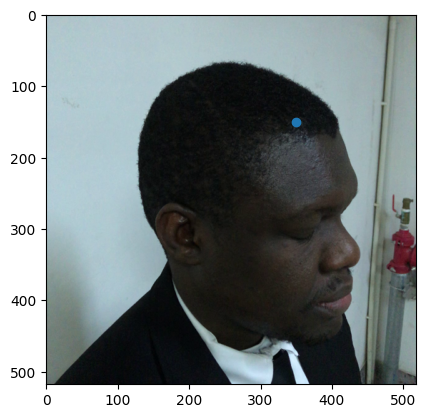

In [5]:
ref_img = images[0][0].cpu().numpy()
ref_img = np.transpose(ref_img, (1, 2, 0))
plt.imshow(ref_img)
plt.scatter(350,150)

In [6]:
with torch.no_grad():
    query_points = np.array([[350.,150.],
                             [200.,200.],
                             [300.,200.],
                             [200.,300.],
                             [250.,350.]])[None]  # [1,2]
    
    query_points = torch.tensor(query_points, device=device).float()
    track_list, vis, track_feats, query_track_feats, conf = model.track_head(aggregated_tokens_list, images, ps_idx, query_points)
    track = track_list[-1]

In [81]:
conf,vis

(tensor([[[0.9978],
          [0.0025]]], device='cuda:0'),
 tensor([[[1.0000],
          [0.7806]]], device='cuda:0'))

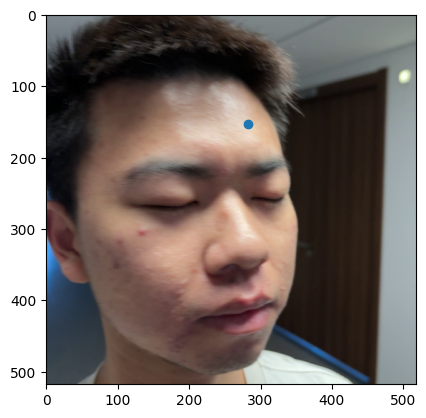

In [82]:
vis_ind = 1

vis_img = images[0][vis_ind].cpu().numpy()
vis_img = np.transpose(vis_img, (1, 2, 0))
plt.imshow(vis_img)
track_point = track[0][vis_ind][0].cpu().numpy()
plt.scatter(track_point[0], track_point[1])

#### 下面保存一些TSDF fusion需要的数据

In [5]:
np.median(depth_conf.cpu().numpy())

2.3328097

In [6]:
depth_select = depth_conf < 2.34
depth_map[depth_select] = 0

In [7]:
np.save("depth_map.npy",depth_map[0].cpu().numpy())
# np.save("depth_conf.npy",depth_conf[0].cpu().numpy())
np.save("extrinsic.npy",extrinsic[0].cpu().numpy())
np.save("intrinsic.npy",intrinsic[0].cpu().numpy())
np.save("images.npy",images[0].cpu().numpy())

In [9]:
point_all = point_map_by_unprojection.reshape(-1, 3)
color_all = images[0].permute(0, 2, 3, 1).reshape(-1, 3).detach().cpu().numpy()
conf_all = depth_conf[0].reshape(-1,).detach().cpu().numpy()
threshold = np.median(conf_all)
conf_mask = conf_all > threshold
point_all = point_all[conf_mask]
color_all = color_all[conf_mask]

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_all)
pcd.colors = o3d.utility.Vector3dVector(color_all)

o3d.io.write_point_cloud("pointcloud.ply", pcd)

True

In [4]:
base_path = "./test_model/"

paths = os.listdir(base_path)

In [5]:
from tqdm import tqdm

for path in tqdm(paths):
    try:
        full_path = os.path.join(base_path, path)
        image_names = sorted(glob.glob(os.path.join(full_path, "*.png")))
        images = load_and_preprocess_images(image_names).to(device)

        with torch.no_grad():
            with torch.cuda.amp.autocast(dtype=dtype):
                images = images[None]  # add batch dimension
                aggregated_tokens_list, ps_idx = model.aggregator(images)
                        
            # Predict Cameras
            pose_enc = model.camera_head(aggregated_tokens_list)[-1]
            # Extrinsic and intrinsic matrices, following OpenCV convention (camera from world)
            extrinsic, intrinsic = pose_encoding_to_extri_intri(pose_enc, images.shape[-2:])

            # Predict Depth Maps
            depth_map, depth_conf = model.depth_head(aggregated_tokens_list, images, ps_idx)

            # # Predict Point Maps
            # point_map, point_conf = model.point_head(aggregated_tokens_list, images, ps_idx)
                
            # Construct 3D Points from Depth Maps and Cameras
            # which usually leads to more accurate 3D points than point map branch
            point_map_by_unprojection = unproject_depth_map_to_point_map(depth_map.squeeze(0), 
                                                                        extrinsic.squeeze(0), 
                                                                        intrinsic.squeeze(0))

        point_all = point_map_by_unprojection.reshape(-1, 3)
        color_all = images[0].permute(0, 2, 3, 1).reshape(-1, 3).detach().cpu().numpy()
        conf_all = depth_conf[0].reshape(-1,).detach().cpu().numpy()
        threshold = np.median(conf_all)
        conf_mask = conf_all > threshold
        point_all = point_all[conf_mask]
        color_all = color_all[conf_mask]

        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(point_all)
        pcd.colors = o3d.utility.Vector3dVector(color_all)

        o3d.io.write_point_cloud(os.path.join(base_path,"vggt_results",path+".ply"), pcd)
        
        torch.cuda.empty_cache()
        
    except:
        print("Error in ", path)
    

  0%|          | 0/23 [00:00<?, ?it/s]/tmp/ipykernel_157973/3641267808.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype):
 13%|█▎        | 3/23 [00:33<04:32, 13.64s/it]

Error in  shadow1_many-view


 35%|███▍      | 8/23 [01:06<02:14,  8.97s/it]

Error in  env2_many-view


 65%|██████▌   | 15/23 [01:56<01:23, 10.47s/it]

Error in  black1_many-view


 74%|███████▍  | 17/23 [02:05<00:43,  7.31s/it]

Error in  vggt_results


100%|██████████| 23/23 [02:26<00:00,  6.39s/it]
